In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import cv2
import os
import imageio

from PIL import Image
from video_dataset import VideoDataset
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from lip_sync_model.model import BiSeNet
from torchvision.ops import masks_to_boxes

### Load model

In [2]:
lip_model_path = '79999_iter.pth'
lip_model = BiSeNet(n_classes=19)
lip_model.load_state_dict(torch.load(lip_model_path))
lip_model.cuda()
lip_model.eval()

BiSeNet(
  (cp): ContextPath(
    (resnet): Resnet18(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
face_ds = VideoDataset(root_dir='dataset/train', height=512, width=512, max_files=100, max_frames=70)

In [3]:
vide_id = "2r3ddBtpQjA_2"
load_mask = "lip_masks/" + vide_id + "_mask.pt"
vid_path = "dataset/train/" + vide_id + ".mp4"

if os.path.exists(load_mask):
    lip_mask = torch.load(load_mask)
    video = imageio.get_reader(vid_path)

In [15]:
# Function to get bounding box from lip mask and create box mask
def get_lip_bbox(lip_mask):
    """
    Extract bounding box coordinates from a lip mask and create a box mask
    
    Args:
        lip_mask: Binary mask tensor with shape (B, N, H, W)
        
    Returns:
        tuple: (x_min, y_min, x_max, y_max, box_mask) or None if no lip pixels found
              where box_mask is a tensor with ones in the bounding box area
    """
    boxes = masks_to_boxes(lip_mask)
   
    # Find non-zero coordinates (lip pixels)
    y_indices, x_indices = torch.where(lip_mask > 0)
       
    # Get min and max coordinates to form bounding box
    x_min = int(torch.min(x_indices))
    y_min = int(torch.min(y_indices))
    x_max = int(torch.max(x_indices))
    y_max = int(torch.max(y_indices))
    
    # Create a new mask with ones in the bounding box area
    box_mask = torch.zeros_like(lip_mask)
    box_mask[y_min:y_max+1, x_min:x_max+1] = 1.0
    
    return box_mask

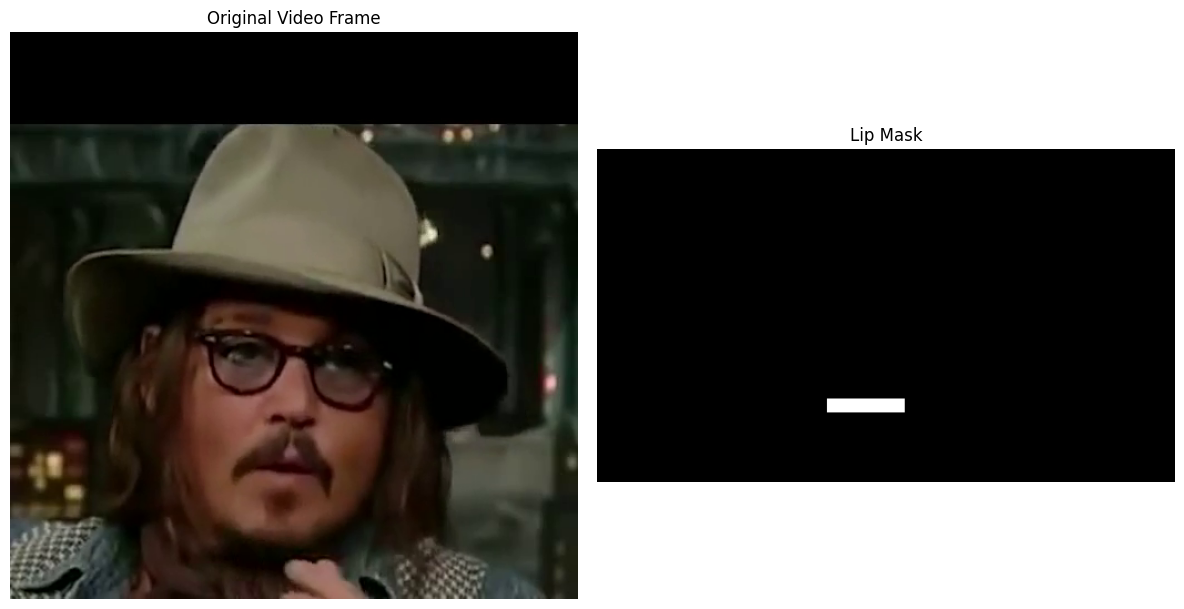

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Test the function on our lip mask
frame_idx = 10
bbox = get_lip_bbox(lip_mask[:frame_idx].unsqueeze(0))

frame = video.get_data(frame_idx)
frame = Image.fromarray(frame)
    
# Display original video frame
axes[0].imshow(frame)
axes[0].set_title('Original Video Frame')
axes[0].axis('off')

# Display lip mask, scaling to 255 for better visibility
axes[1].imshow(bbox.cpu().numpy() * 255, cmap='gray')
axes[1].set_title('Lip Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [31]:
# Process the output to get the parsing map using torch operations
def get_lip_mask(out):
    parsing = torch.argmax(out, dim=2)
    print(torch.unique(parsing))

    # Create a binary mask for lips (class 12 is upper lip, 13 is lower lip)
    lip_mask = torch.zeros_like(parsing, dtype=torch.float)
    lip_mask[(parsing == 12) | (parsing == 13)] = 1
    
    return lip_mask

In [40]:
# Create mask
video_id = "YNfuzJwLcT8_2"
vid_path = "dataset/train/" + video_id + ".mp4"
video = imageio.get_reader(vid_path)
frame = np.array(video.get_data(10)).astype(np.float32)

In [41]:
with torch.no_grad():
    prep_frame = torch.from_numpy(frame).unsqueeze(0).unsqueeze(0).reshape(1, 1, 3, 512, 512).cuda()

    out = lip_model(prep_frame)[0]

In [ ]:

mask = get_lip_mask(out)
mask = mask.squeeze(0).cpu().numpy()

In [31]:
i = 20

with torch.no_grad():
    out = lip_model(torch.stack([face_ds[i][0],face_ds[i+1][0],face_ds[i+2][0]]).to('cuda'))[0]

In [6]:
def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='vis_results/parsing_map_on_im.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

    # return vis_im

In [ ]:
# view lip mask and original video side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

video_idx = 1
frame_idx = 50
# Display original video frame
axes[0].imshow(face_ds[video_idx][0][frame_idx].permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Original Video Frame')
axes[0].axis('off')

# Display lip mask, scaling to 255 for better visibility
axes[1].imshow(lip_mask[video_idx][frame_idx].cpu().numpy() * 255, cmap='gray')
axes[1].set_title('Lip Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
lip_mask_tensor = lip_mask[0].to(torch.uint8)  # uint8 is the smallest int format for binary mask
torch.save(lip_mask_tensor, 'lip_mask.pt')
print(f"Lip mask tensor saved with shape: {lip_mask_tensor.shape}")